In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc
import seaborn as sns
import missingno as msno
import warnings
warnings.filterwarnings('ignore')

import requests
import math
import random
from bs4 import BeautifulSoup

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from tqdm import tqdm
import re
import collections
from wordcloud import STOPWORDS
from scipy.sparse import csr_matrix
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from wordcloud import WordCloud
from konlpy.tag import Okt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import SGDRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve, auc

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RYU\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\RYU\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


<font color=#cccccc>6조. MID_PR (영화 리뷰 데이터 : 감성분류 & 긍정/부정 키워드 분석)</font>
==

 # <font color=#cccccc>데이터 수집</font>
 - 
    - 감성분류를 위한 텍스트 영화리뷰 데이터(네이버영화)<br><br>
    - 평점 / 리뷰 데이터를 수집하여 평점이 낮은 리뷰에 부정적 단어와 높은점수의 리뷰에서 긍정단어를 추출

### <font color=yellow>WebScraping</font>

In [ ]:
url = "https://movie.naver.com/movie/point/af/list.nhn?&page="
headers = {'User-Agent' : 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.101 Safari/537.36'}
movie_list = []
numb_list = []
score_list = []
comment_list = []
for page in range(1,1001):
    web = requests.get(url+str(page), headers = headers).content
    soup = BeautifulSoup( web, 'html.parser')
    numb = soup.find_all('td', {"class":"ac num"})
    
#     movie_title = td.select_one('a.movie').text.strip()
#     score = td.select_one('div.list_netizen_score > em').text.strip()
#     comment = td.select_one('br').next_sibling.strip()
    
    for numb in numb:
        numb_list.append(numb.text)
    movie_name_lst = soup.find_all('a', {"class":"movie color_b"})
    for movie_name in movie_name_lst:
        movie_list.append(movie_name.text)
    star_score_lst = soup.find_all('div',{'class':"list_netizen_score"})
    for star_score in star_score_lst:
        score_list.append(star_score.find('em').text)
    comment_lst = soup.find_all('td', {'class':"title"})
    for comment in comment_lst:
        comment_list.append(comment.select_one('br').next_sibling.strip())      

![크롤링.jpg](크롤링.jpg)

In [ ]:
# # Crawling 방법 2
# url = "https://movie.naver.com/movie/point/af/list.nhn?&page="
# headers = {'User-Agent' : 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.101 Safari/537.36'}

# movie_list = []
# numb_list = []
# score_list = []
# comment_list = []


## Tag 꺼내기
# for page in range(1,1001):
#     web = requests.get(url+str(page), headers = headers).content
#     soup = BeautifulSoup( web, 'html.parser')
    
#     numb = soup.find_all('td', {"class":"ac num"})
#     for numb in numb:
#         numb_list.append(numb.text)
        
#     movie_name_lst = soup.find_all('a', {"class":"movie color_b"})
#     for movie_name in movie_name_lst:
#         movie_list.append(movie_name.text)
    
#     star_score_lst = soup.find_all('div',{'class':"list_netizen_score"})
#     for star_score in star_score_lst:
#         score_list.append(star_score.find('em').text)
        
#     comment_lst = soup.find_all('td', {'class':"title"})
#     for comment in comment_lst:

#         # br class 다음 문자열을 불러옴. next_sibling
#         comment_list.append(comment.select_one('br').next_sibling.strip())
    
#     interval = round(random.uniform(0.2, 1.2),2)
#     time.sleep(interval)

# # list로 받아진 데이터들을 zip함수를 이용해 합치고, column 명을 넣어준다.
# df = pd.DataFrame([ x for x in zip(numb_list, movie_list, score_list, comment_list)], columns=['리뷰번호','영화명','평점','리뷰'])

In [ ]:
df_movie_list   = pd.DataFrame(movie_list, columns   = ['title'])
df_numb_list    = pd.DataFrame(numb_list, columns    = ['number'])
df_score_list   = pd.DataFrame(score_list, columns   = ['score'])
df_comment_list = pd.DataFrame(comment_list, columns = ['text'])

In [ ]:
df_final = pd.concat([df_movie_list,df_numb_list,df_score_list,df_comment_list], axis=1)
df_final.to_csv('naver_movie.csv', encoding='utf-8', index=False)

In [55]:
df = pd.read_csv('naver_movie.csv', encoding='utf-8')
df.head()

,title,number,score,text
0,콰이어트 플레이스 2,17583235,9,1편보다 재밌고 3편이 기대되는 2편
1,히든 피겨스,17583234,10,엄청 재밌어요! 후회 절대 안하실 겁니다! 너무 재밌어서 자막없이 한 번 더 보려고...
2,맘마미아!,17583233,8,"그리스 배경에 청량한 느낌, 항상 웃고 있는 배우분들의 표정, 중독성 강한 Ost까..."
3,마이 캡틴 김대출,17583232,1,배우가 ㅈ같네....
4,열아홉,17583231,10,손영주 배우의 연기가 참 좋네요 추천합니다


 # <font color=#cccccc>data exploration</font>

### <font color=yellow>결측치 확인 / information</font>

In [56]:
print('###################결측치#######################')
print(df.isnull().sum())
print('---------------------------------------------')
print('#################데이터정보#####################')
print(df.info())

###################결측치#######################
title       0
number      0
score       0
text      533
dtype: int64
---------------------------------------------
#################데이터정보#####################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
title     10000 non-null object
number    10000 non-null int64
score     10000 non-null int64
text      9467 non-null object
dtypes: int64(2), object(2)
memory usage: 312.6+ KB
None


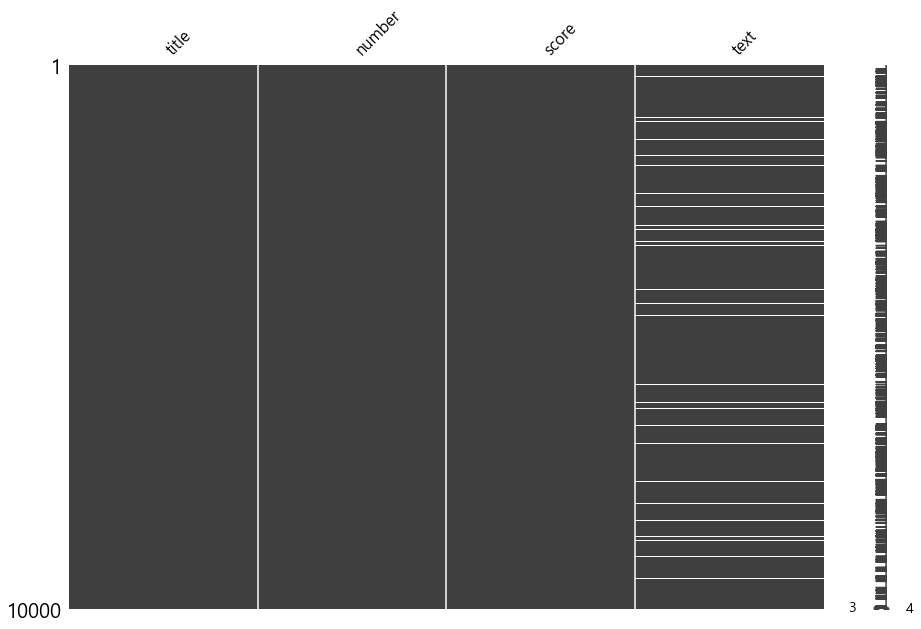

In [57]:
msno.matrix(df, figsize=(15,10))

In [115]:
# drop된 row를 제거하고, re indexing
df.dropna(axis = 0, inplace=True)
df.reset_index(inplace=True)
del df['index']

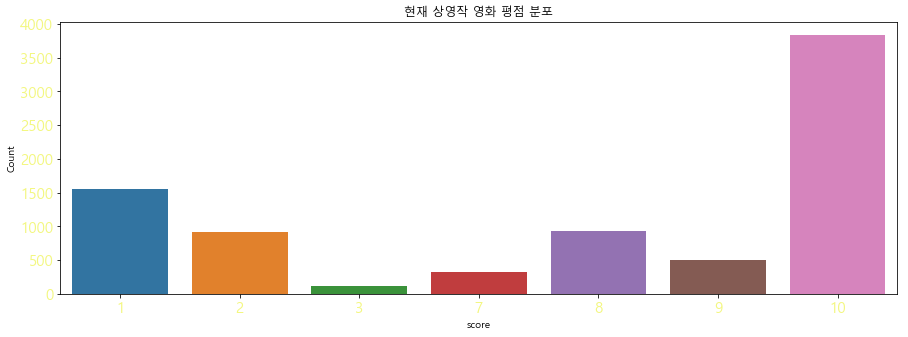

In [116]:
font_name = matplotlib.font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name() # NanumGothic.otf
matplotlib.rc('font', family=font_name)
plt.rc('font')

count=df['score'].value_counts()

plt.figure(figsize=(15,5))
plt.xticks(color='#F3F781', fontsize =15) 
plt.yticks(color='#F3F781', fontsize =15)
sns.barplot(count.index,count)
plt.title("현재 상영작 영화 평점 분포")
plt.xlabel('score')
plt.ylabel('Count')
plt.show()

#### 추가추가추가 (4,5,6점 날리기)

In [118]:
df = df[(df['score']<=3) | (df['score']>=7)]
df.reset_index(inplace=True)
del df['index']
df

,title,number,score,text,y
0,콰이어트 플레이스 2,17583235,9,1편보다 재밌고 3편이 기대되는 2편,1
1,히든 피겨스,17583234,10,엄청 재밌어요! 후회 절대 안하실 겁니다! 너무 재밌어서 자막없이 한 번 더 보려고...,1
2,맘마미아!,17583233,8,"그리스 배경에 청량한 느낌, 항상 웃고 있는 배우분들의 표정, 중독성 강한 Ost까...",1
3,마이 캡틴 김대출,17583232,1,배우가 ㅈ같네....,0
4,열아홉,17583231,10,손영주 배우의 연기가 참 좋네요 추천합니다,1
5,콰이어트 플레이스 2,17583230,10,역시 실망시키지 않았음,1
6,가을의 전설,17583229,8,OST가 너무 강렬해서 들을때마다 가슴이 괜히 뭉클해져,1
7,채피,17583227,10,인간의 탐욕과 이기심을 적나라하게 드러낸 명작,1
8,발신제한,17583226,7,그냥 한국영화 그 자체 조우진 연기는 볼만했음,1
9,미드나이트,17583225,8,보는내내 긴장감 있었어요진기주 위하준 연기대박!,1


 # <font color=#cccccc>한글 텍스트 전처리</font>

### <font color=yellow>정규표현식 함수를 정의</font>

In [119]:
def apply_regular_expression(text):
    hangul = re.compile('[^ ㄱ-ㅣ 가-힣]')  # 한글 추출 규칙: 띄어 쓰기(1 개)를 포함한 한글
    result = hangul.sub('', text)  # 위에 설정한 "hangul"규칙을 "text"에 적용(.sub)시킴
    return result

In [120]:
apply_regular_expression(df['text'][0])

'편보다 재밌고 편이 기대되는 편'

### <font color=yellow>Konlpy라이브러리의 Okt객체를 통한 명사 형태소 추출</font>

In [121]:
okt = Okt()  # 명사 형태소 추출 함수
nouns = okt.nouns(apply_regular_expression(df['text'][0]))
nouns

['편', '편이', '기대', '편']

### <font color=yellow>말 뭉치 생성 / 정규표현식 적용</font>

In [122]:
corpus = "".join(df['text'].tolist())
corpus[:100]

'1편보다 재밌고 3편이 기대되는 2편엄청 재밌어요! 후회 절대 안하실 겁니다! 너무 재밌어서 자막없이 한 번 더 보려고 합니다. 꼭 보세오 후회 안합니다!!그리스 배경에 청량한 느'

In [123]:
# 정규 표현식 적용
corpus_accept = apply_regular_expression(corpus)
print(corpus_accept[:1000])

편보다 재밌고 편이 기대되는 편엄청 재밌어요 후회 절대 안하실 겁니다 너무 재밌어서 자막없이 한 번 더 보려고 합니다 꼭 보세오 후회 안합니다그리스 배경에 청량한 느낌 항상 웃고 있는 배우분들의 표정 중독성 강한 까지 정말 작품성이 높은 탄탄한 스토리는 아니지만 행복해지고 싶을 때 보는 인생 영화배우가 ㅈ같네손영주 배우의 연기가 참 좋네요 추천합니다역시 실망시키지 않았음가 너무 강렬해서 들을때마다 가슴이 괜히 뭉클해져인간의 탐욕과 이기심을 적나라하게 드러낸 명작그냥 한국영화 그 자체 조우진 연기는 볼만했음보는내내 긴장감 있었어요진기주 위하준 연기대박마지막 말이 압권이었음자신이 어떻게 죽을지 몰라야 인생을 사는게 재밌다는게발암전개가 안타깝지만 편을 위한 숨고르기라 믿고 싶다개인적으로 너무 좋았습니다왜 평점은 마이너스가 없나요배우들은 대단한거같아요 어떤상황이든 감정이입을 해야하니까ㅠㅠ 이런 ㅈ같은장르의 영화에서도최선을다한 배우들에겐 높이평가합니다한국이아니라 타이완이나ㅠ베트남쪽 사람들데리고 영화만드셧음ㅜ좋겟어요배우들 연기나 연출모두 좋았고 사람마다 와닿는 바가 다르겠지만 나한텐 개인적으로 울림이있는 영화였다고 생각한다 단순히 하니 연기가 궁금해서 봤는데 괜히 먹먹하고 복잡한 생각이 드는인간의 교감은 말로 설명할 수 없는 것 같다그게 어떤 관계이든간에 재밌다 원빈 얼굴도내용도여고생 연기잘함 개소름시간가는줄 모르고 봤습니다명작 추격자도 답답혀 개연성 따지지 말어년 영화라니 개봉할 때 봤을 때보다 훨씬 다층적으로 생각하고 느낄 수 있었다 와의 사랑이 납득되는 걸 보니 다양성에 관한 영화이기도 하고 당연히 사랑과 관계에 관한 영화이기도 하고 성장에 관한 영화이기도 하다 미술 디자인이 다시 봐도 곱고밤인지 새벽인지 경계가 모호한 도심의 시간과 공간 표현도 좋다그리고 무엇보다    연기가 너무 좋다 조커나 마스터 같은 연기도 좋지만 이런 역도 좀 다시 해줬으면 좋겠다주인공 연기를 보고 마지막에 눈물이 갑자기 흘렀습니다연기가 대단하시네요많은 시간을 함께 보내서 서로에 대해 잘 

#### <font color=yellow>POS Tagging</font>

In [124]:
raw_pos_tagged = okt.pos(corpus, norm=True, stem=True) # POS Tagging, norm=True:정규화, stem=True:어근
raw_pos_tagged

[('1', 'Number'),
 ('편', 'Noun'),
 ('보다', 'Josa'),
 ('재밌다', 'Adjective'),
 ('3', 'Number'),
 ('편이', 'Noun'),
 ('기대', 'Noun'),
 ('되다', 'Verb'),
 ('2', 'Number'),
 ('편', 'Noun'),
 ('엄청', 'Adverb'),
 ('재밌다', 'Adjective'),
 ('!', 'Punctuation'),
 ('후회', 'Noun'),
 ('절대', 'Noun'),
 ('안', 'VerbPrefix'),
 ('하다', 'Verb'),
 ('겁니다', 'Verb'),
 ('!', 'Punctuation'),
 ('너무', 'Adverb'),
 ('재밌다', 'Adjective'),
 ('자막', 'Noun'),
 ('없이', 'Adverb'),
 ('하다', 'Verb'),
 ('번', 'Noun'),
 ('더', 'Noun'),
 ('보다', 'Verb'),
 ('하다', 'Verb'),
 ('.', 'Punctuation'),
 ('꼭', 'Noun'),
 ('보다', 'Verb'),
 ('후회', 'Noun'),
 ('안', 'VerbPrefix'),
 ('하다', 'Verb'),
 ('!!', 'Punctuation'),
 ('그리스', 'Noun'),
 ('배경', 'Noun'),
 ('에', 'Josa'),
 ('청량하다', 'Adjective'),
 ('느낌', 'Noun'),
 (',', 'Punctuation'),
 ('항상', 'Noun'),
 ('웃다', 'Verb'),
 ('있다', 'Adjective'),
 ('배우', 'Noun'),
 ('분들', 'Suffix'),
 ('의', 'Josa'),
 ('표정', 'Noun'),
 (',', 'Punctuation'),
 ('중독', 'Noun'),
 ('성', 'Suffix'),
 ('강하다', 'Adjective'),
 ('Ost', 'Alpha'),
 ('까지',

 # <font color=#cccccc>불용어사전 정의 / 단어 빈도수 확인</font>

### <font color=yellow>초기 단어 빈도수 확인</font>

In [125]:
# 빈도 탐색
from collections import Counter

counter_all_comment = Counter(raw_pos_tagged)
counter_all_comment.most_common(10)

[(('.', 'Punctuation'), 5641),
 (('하다', 'Verb'), 4082),
 (('영화', 'Noun'), 3761),
 (('이', 'Josa'), 3583),
 (('보다', 'Verb'), 3527),
 (('가', 'Josa'), 2384),
 (('에', 'Josa'), 2383),
 (('의', 'Josa'), 2204),
 (('을', 'Josa'), 2067),
 (('들', 'Suffix'), 1899)]

In [126]:
# set 함수를 사용하여 raw_pos_tagged pos값을 가져오고 중복은 제거한 순수한 pos값을 남긴다.
set_of_tag = set()
for tag in raw_pos_tagged:
    set_of_tag.add(tag[1])
print(set_of_tag)

{'Adverb', 'Determiner', 'Alpha', 'PreEomi', 'KoreanParticle', 'Exclamation', 'Number', 'Suffix', 'Adjective', 'Punctuation', 'Eomi', 'Verb', 'Hashtag', 'Noun', 'URL', 'Conjunction', 'Foreign', 'Josa', 'Modifier', 'VerbPrefix'}


1글자 명사 제거
#위 결과에서 보이듯이, 두 글자 키워드가 대부분 의미 있는 단어지만,  ‘것’, '더’과 
#같은 한 글자 키워드는 분석에 딱히 좋은 영향을 미치지 않은 것으로 보임.
#한글자 명사를 제거.

available_counter = Counter({x: counter[x] for x in counter if len(x) > 1})
available_counter.most_common(10)

### <font color=yellow>불용어 사전 정의</font>

In [127]:
# 링크의 불용어 사전에, 현재데이터에서 빈도수가 높지만 감정과 관련없는 단어도 추가하여 불용어 사전을 정의 한다.
stopwords = pd.read_csv("https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/korean_stopwords.txt").values.tolist()
stop_words = set([x[0] for x in stopwords])
movie_words = {'하다', '보다','있다','없다','너무','이다','영화',
           '되다','않다','같다','만들다','그냥','보고','정말',
           '가다','들다','진짜','싶다','정도','오다','많다',
           '연기','배우','그리고','부분','나다','편이','분들',
            '작품','영화','아니다','되는','겁니다','감독','합니다','싶을','같네'}
stop_words = stop_words.union(movie_words)

In [128]:
# li = list([[1,2,3],[4,5,6]])
# sum(li,[])

In [129]:
# 반복 시행을 통해 추가 불용어에 pos tagging 한다.

word_cleaned = []

for word in raw_pos_tagged:
    if word[1] not in ["Josa", "Eomi", "Punctuation", "Foreign", "Number", "Hashtag", "URL","PreEomi"]: 
        if (len(word[0]) != 1) & (word[0] not in stop_words):
            word_cleaned.append(word[0])
        else :
            stop_words.add(word[0])
        
stop_words_lst = list(stop_words)
word_cleaned[:10]

['재밌다', '기대', '엄청', '재밌다', '후회', '절대', '재밌다', '자막', '없이', '후회']

In [130]:
result = Counter(word_cleaned)
word_dic = dict(result)
word_dic

{'재밌다': 995,
 '기대': 162,
 '엄청': 67,
 '후회': 51,
 '절대': 67,
 '자막': 19,
 '없이': 198,
 '그리스': 1,
 '배경': 37,
 '청량하다': 5,
 '느낌': 242,
 '항상': 21,
 '웃다': 63,
 '표정': 31,
 '중독': 6,
 '강하다': 23,
 'Ost': 3,
 '높다': 80,
 '탄탄하다': 45,
 '스토리': 792,
 '행복하다': 40,
 '인생': 170,
 '영화배우': 4,
 '손영주': 1,
 '차다': 123,
 '좋다': 1271,
 '추천': 163,
 '역시': 125,
 '실망': 39,
 'OST': 33,
 '강렬하다': 9,
 '가슴': 80,
 '괜히': 18,
 '뭉클하다': 16,
 '인간': 78,
 '탐욕': 2,
 '이기심': 2,
 '적나라하다': 5,
 '드러내다': 10,
 '명작': 87,
 '한국영': 54,
 '자체': 98,
 '조우진': 152,
 '긴장감': 206,
 '진기': 127,
 '대박': 96,
 '마지막': 238,
 '어떻다': 156,
 '죽다': 83,
 '모르다': 361,
 '살다': 126,
 '발암': 54,
 '전개': 139,
 '안타깝다': 60,
 '고르다': 18,
 '기르다': 6,
 '믿다': 130,
 '개인': 86,
 '평점': 368,
 '마이너스': 6,
 '대단하다': 62,
 '상황': 82,
 '감정이입': 10,
 'ㅠㅠ': 214,
 '이렇다': 306,
 '장르': 63,
 '최선': 5,
 '다한': 10,
 '높이': 8,
 '평가': 38,
 '한국': 135,
 '타이완': 2,
 '베트남': 3,
 '사람': 446,
 '데리': 12,
 '드셧': 1,
 '연출': 404,
 '닿다': 19,
 '다르다': 53,
 '한텐': 4,
 '울리다': 14,
 '생각': 594,
 '단순하다': 25,
 '하니': 12,
 '궁금하다': 43,
 '먹다':

In [131]:
# 출연빈도수가 높은 단어들로 내림차순하여 빈도수 top10을 확인한다.
sorted_word_dic = sorted(word_dic.items(), key=lambda x:x[1], reverse=True)
sorted_word_dic[:10]

[('좋다', 1271),
 ('재밌다', 995),
 ('스토리', 792),
 ('생각', 594),
 ('나오다', 522),
 ('자다', 490),
 ('사람', 446),
 ('연출', 404),
 ('최고', 384),
 ('평점', 368)]

### <font color=yellow>단어출연빈도 시각화</font>

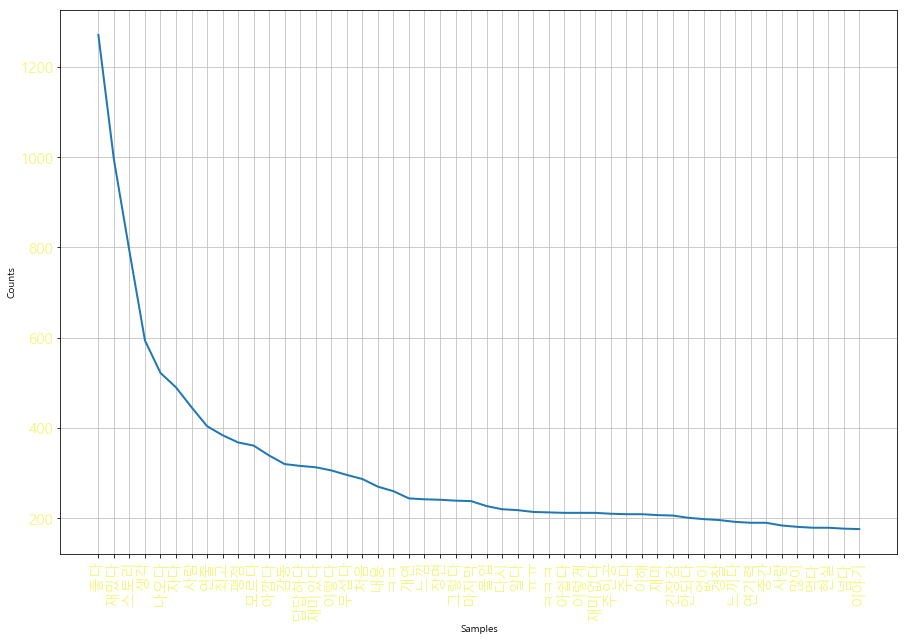

In [132]:
word_counted = nltk.Text(word_cleaned) 
plt.figure(figsize=(15, 10))
plt.rc('font')
#plt.gca().set_facecolor('black') #배경색
plt.xticks(color='#F3F781', fontsize =15) 
plt.yticks(color='#F3F781', fontsize =15) 
word_counted.plot(50)

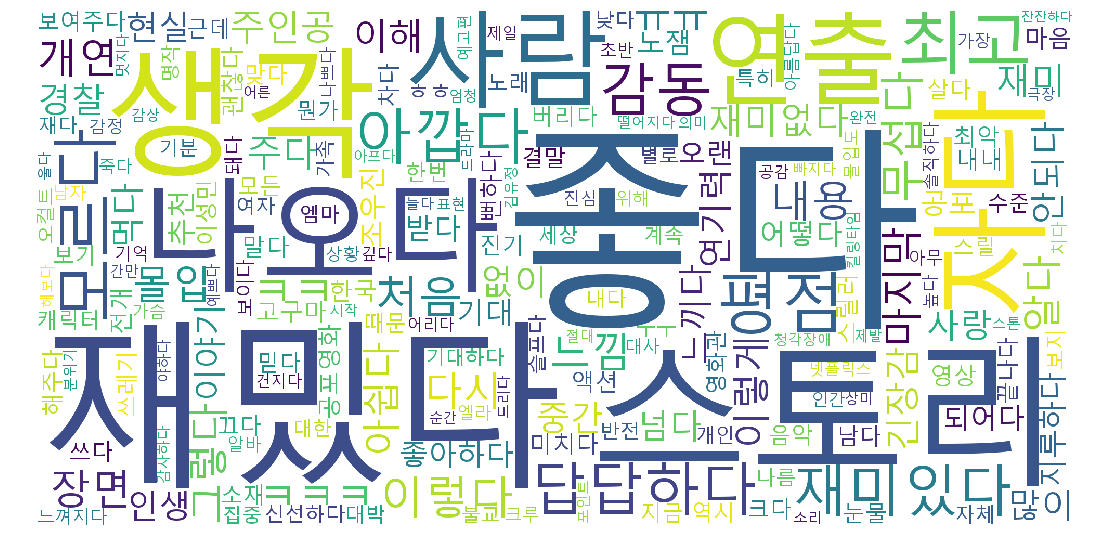

In [133]:
word_cloud = WordCloud(font_path="C:/Windows/Fonts/malgun.ttf",
                       width=2000, height=1000, 
                       background_color='white')
word_cloud.generate_from_frequencies(word_dic)

plt.figure(figsize=(15,15))
plt.imshow(word_cloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

 # <font color=#cccccc>Feature Vectorizer 적용 / 단어 빈도수 확인</font>

### <font color=yellow>Counter Vectorizer</font>

In [134]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [539]:
def text_cleaning(text):
    hangul = re.compile('[^ a-z A-Z ㄱ-ㅣ 가-힣]')  # 정규 표현식 처리
    result = hangul.sub('', text)
    okt = Okt()  # 형태소 추출
    words = okt.morphs(result, norm=True)
    words = [x for x in words if len(x) > 1]  # 한글자 키워드 제거
    words = [x for x in words if x not in stop_words_lst]  # 불용어 제거
    return words

vect = CountVectorizer(tokenizer = lambda x: text_cleaning(x))
bow_vect = vect.fit_transform(df['text'].tolist())
word_list = vect.get_feature_names()
count_list = bow_vect.toarray().sum(axis=0)

### <font color=yellow>Counter Vectorizer 적용결과</font>

In [540]:
# 단어 리스트
pd.DataFrame(word_list).tail(50)

,0
20481,힘내라
20482,힘내서
20483,힘내세요
20484,힘드
20485,힘드네
20486,힘드셨나
20487,힘드셨을듯
20488,힘드시다는
20489,힘드실
20490,힘든


In [541]:
# 각 단어가 전체 리뷰중에 등장한 총 횟수
pd.DataFrame(count_list[:10])

,0
0,1
1,1
2,2
3,5
4,2
5,1
6,1
7,1
8,1
9,1


In [542]:
# 각 단어의 자신의 리뷰의 등장 횟수
pd.DataFrame(bow_vect.toarray()[:10])

,0,1,2,3,4,5,6,7,8,9,...,20521,20522,20523,20524,20525,20526,20527,20528,20529,20530
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [543]:
bow_vect.shape

(8182, 20531)

In [544]:
# "단어" - "총 등장 횟수" Matching

#zip() 함수는 여러 개의 순회 가능한(iterable) 객체를 인자로 받고, 
#각 객체가 담고 있는 원소를 튜플의 형태로 차례로 접근할 수 있는 반복자(iterator)를 반환한다.

word_count_dict = dict(zip(word_list, count_list))
word_Freq = pd.DataFrame(word_count_dict.items())
word_Freq.tail(20)

,0,1
20511,힘들었습니다,1
20512,힘들었어요,2
20513,힘들었으나,1
20514,힘들었을,1
20515,힘들었을듯,1
20516,힘들었을지,1
20517,힘들었을텐데,1
20518,힘들었지만,1
20519,힘들지만,2
20520,힘들텐데,3


### <font color=yellow>Tf-Idf Vectorizer 객체 생성 / 적용</font>

In [545]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_vectorizer = TfidfTransformer()
tf_idf_vect = tfidf_vectorizer.fit_transform(bow_vect)

In [546]:
# 첫 번째 리뷰에서의 단어 중요도(TF-IDF 값) -- 0이 아닌 것만 출력
print(tf_idf_vect[0])

  (0, 15651)	0.7694080248262498
  (0, 2366)	0.6387576154794312


In [547]:
# 첫 번째 리뷰에서 모든 단어의 중요도 -- 0인 값까지 포함
print(tf_idf_vect[0].toarray().shape)
print(tf_idf_vect[0].toarray())

(1, 20531)
[[0. 0. 0. ... 0. 0. 0.]]


### <font color=yellow>“벡터”  &  “단어” mapping</font>

In [548]:
vect.vocabulary_

{'재밌고': 15651,
 '기대': 2366,
 '엄청': 12858,
 '재밌어요': 15696,
 '후회': 20278,
 '절대': 15997,
 '하실': 19361,
 '재밌어서': 15692,
 '자막': 15240,
 '없이': 13024,
 '보려고': 8594,
 '보세오': 8621,
 '그리스': 2211,
 '배경': 8157,
 '청량한': 17810,
 '느낌': 4106,
 '항상': 19627,
 '웃고': 13944,
 '있는': 15031,
 '표정': 18961,
 '중독': 16764,
 '강한': 1081,
 'ost': 346,
 '높은': 3908,
 '탄탄한': 18422,
 '스토리': 10852,
 '아니지만': 11749,
 '행복해지고': 19937,
 '보는': 8539,
 '인생': 14763,
 '손영주': 10578,
 '좋네요': 16368,
 '추천': 17956,
 '역시': 13196,
 '실망': 11180,
 '시키지': 11045,
 '않았음': 12239,
 '강렬해서': 1055,
 '들을': 5620,
 '마다': 6236,
 '가슴': 778,
 '괜히': 1868,
 '뭉클해져': 7562,
 '인간': 14727,
 '탐욕': 18443,
 '이기심': 14359,
 '적나라하게': 15874,
 '드러낸': 5431,
 '명작': 7083,
 '한국영': 19455,
 '자체': 15298,
 '조우진': 16224,
 '했음': 19910,
 '보는내내': 8554,
 '긴장감': 2501,
 '있었어요': 15116,
 '진기': 17107,
 '대박': 4684,
 '마지막': 6299,
 '이었음': 14631,
 '죽을지': 16680,
 '몰라야': 7230,
 '사는게': 9718,
 '재밌다는게': 15679,
 '발암': 8091,
 '전개': 15923,
 '안타깝지만': 12151,
 '고르': 1603,
 '기라': 2411,
 '믿고': 7751,
 '

In [549]:
invert_index_vectorizer = {v: k for k, v in vect.vocabulary_.items()}
print(str(invert_index_vectorizer)[:100]+'...')

{15651: '재밌고', 2366: '기대', 12858: '엄청', 15696: '재밌어요', 20278: '후회', 15997: '절대', 19361: '하실', 15692:...


In [550]:
def rating_to_label(score):
    if score > 5:
        return 1
    else:
        return 0
    
df['y'] = df['score'].apply(lambda x: rating_to_label(x))

In [551]:
df['y'].head()

0    1
1    1
2    1
3    0
4    1
Name: y, dtype: int64

In [552]:
df["y"].value_counts()

1    5596
0    2586
Name: y, dtype: int64

# <font color=#cccccc>모델 학습 / 예측</font>

### <font color=yellow>데이터셋 분리</font>

In [553]:
from sklearn.model_selection import train_test_split

x_data = tf_idf_vect
y_data = df['y']
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.3, random_state=0)
x_train.shape, y_train.shape

((5727, 20531), (5727,))

### <font color=yellow>LogisticRegression</font>

In [554]:
# 로지스틱 리그레션 모델 학습
lr = LogisticRegression(random_state = 0)
lr.fit(x_train, y_train)

# 예측
lr_pred = lr.predict(x_test)

# 분류결과 스코어
print('accuracy: %.4f' % accuracy_score(y_test, lr_pred))
print('precision: %.4f' % precision_score(y_test, lr_pred))
print('recall: %.4f' % recall_score(y_test, lr_pred))
print('F1: %.4f' % f1_score(y_test, lr_pred))

accuracy: 0.8041
precision: 0.7872
recall: 0.9709
F1: 0.8695


In [555]:
print(metrics.classification_report(y_test, lr_pred))

              precision    recall  f1-score   support

           0       0.89      0.46      0.61       805
           1       0.79      0.97      0.87      1650

   micro avg       0.80      0.80      0.80      2455
   macro avg       0.84      0.72      0.74      2455
weighted avg       0.82      0.80      0.78      2455



### <font color=yellow>Ada-Boosting</font>

In [556]:
from sklearn import ensemble

AB = ensemble.AdaBoostClassifier(random_state=0)
AB.fit(x_train, y_train)
AB_pred = AB.predict(x_test)

print('accuracy: %.4f' % accuracy_score(y_test, AB_pred))
print('precision: %.4f' % precision_score(y_test, AB_pred))
print('recall: %.4f' % recall_score(y_test, AB_pred))
print('F1: %.4f' % f1_score(y_test, AB_pred))

accuracy: 0.7686
precision: 0.7697
recall: 0.9358
F1: 0.8446


### <font color=yellow>xgboost</font>

In [557]:
from xgboost import XGBClassifier

XGB = XGBClassifier(random_state=0)
XGB.fit(x_train, y_train)
acc = accuracy_score(y_test, XGB.predict(x_test))
XGB_pred = XGB.predict(x_test)
print("The accuracy score on test set: {:.4f}".format(acc))
print('precision: %.4f' % precision_score(y_test, XGB_pred))
print('recall: %.4f' % recall_score(y_test, XGB_pred))
print('F1: %.4f' % f1_score(y_test, XGB_pred))

The accuracy score on test set: 0.7621
precision: 0.7463
recall: 0.9788
F1: 0.8469


### <font color=yellow>혼동행렬 시각화</font>

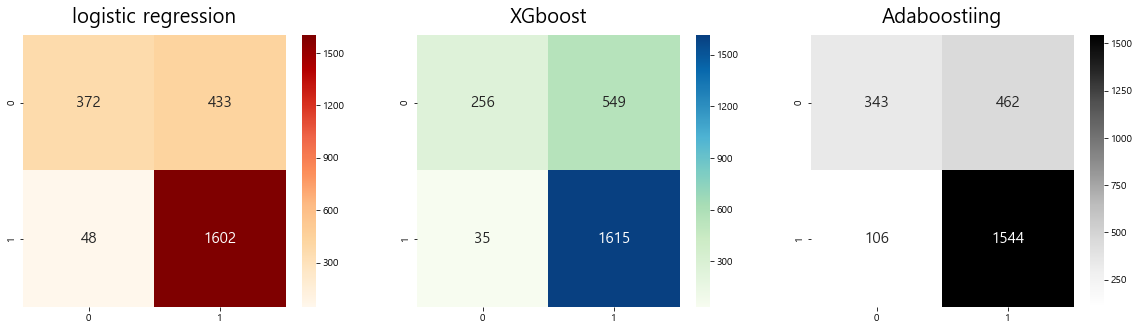

In [558]:
# confusion matrix
from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(20, 5))

confu = confusion_matrix(y_true = y_test, y_pred = lr_pred)
confu2 = confusion_matrix(y_true = y_test, y_pred = XGB_pred)
confu3 = confusion_matrix(y_true = y_test, y_pred = AB_pred)


sns.heatmap(confu, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g', ax=ax[0])
sns.heatmap(confu2, annot=True, annot_kws={'size':15}, cmap='GnBu', fmt='.10g', ax=ax[1])
sns.heatmap(confu3, annot=True, annot_kws={'size':15}, cmap='Greys', fmt='.10g', ax=ax[2])
ax[0].set_title('logistic regression',pad = 12, fontsize = 20)
ax[1].set_title('XGboost',pad = 12, fontsize = 20)
ax[2].set_title('Adaboostiing',pad = 12, fontsize = 20)
plt.show()

### <font color=yellow>클래스 불균형 보정 / 모델 재학습</font>

In [559]:
# 긍정리뷰와 부정리뷰의 적절한 균형 보정이 필요하다.
df['y'].value_counts()

1    5596
0    2586
Name: y, dtype: int64

In [560]:
#긍정 리뷰와 부정리뷰에서 각각 부정리뷰 만큼의 무작위 인덱스 값을 추출 하여 랜덤 인덱스 값을 만들고 
# 만들어진 랜덤 인덱스 값을 토데로 각각 X,Y데이터의 균형을 맞춘다.
positive_random_idx = df[df['y']==1].sample(df['y'].value_counts()[0], random_state=0).index.tolist()
negative_random_idx = df[df['y']==0].sample(df['y'].value_counts()[0], random_state=0).index.tolist()

In [561]:
random_idx = positive_random_idx + negative_random_idx
x_data = tf_idf_vect[random_idx]
y_data = df['y'][random_idx]
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=0)

In [562]:
x_train.shape, y_train.shape

((3620, 20531), (3620,))

#### <font color=yellow>LogisticRegression</font>

In [563]:
lr2 = LogisticRegression(random_state = 0)
lr2.fit(x_train, y_train)
lr2_pred = lr2.predict(x_test)

# classification result for test set
print('accuracy: %.2f' % accuracy_score(y_test, lr2_pred))
print('precision: %.2f' % precision_score(y_test, lr2_pred))
print('recall: %.2f' % recall_score(y_test, lr2_pred))
print('F1: %.2f' % f1_score(y_test, lr2_pred))

print(metrics.classification_report(y_test, lr2_pred))

accuracy: 0.83
precision: 0.80
recall: 0.87
F1: 0.84
              precision    recall  f1-score   support

           0       0.87      0.80      0.83       801
           1       0.80      0.87      0.84       751

   micro avg       0.83      0.83      0.83      1552
   macro avg       0.84      0.84      0.83      1552
weighted avg       0.84      0.83      0.83      1552



#### <font color=yellow>Ada-Boosting</font>

In [564]:
AB2 = ensemble.AdaBoostClassifier(random_state=0)
AB2.fit(x_train, y_train)
AB2_pred = AB2.predict(x_test)

print('accuracy: %.2f' % accuracy_score(y_test, AB2_pred))
print('precision: %.2f' % precision_score(y_test, AB2_pred))
print('recall: %.2f' % recall_score(y_test, AB2_pred))
print('F1: %.2f' % f1_score(y_test, AB2_pred))

accuracy: 0.67
precision: 0.60
recall: 0.94
F1: 0.73


#### <font color=yellow>XGBoost</font>

In [565]:
from xgboost import XGBClassifier

XGB2 = XGBClassifier(random_state=0)
XGB2.fit(x_train, y_train)
acc = accuracy_score(y_test, XGB2.predict(x_test))
XGB2_pred = XGB2.predict(x_test)
print('accuracy: %.2f' % accuracy_score(y_test, XGB2_pred))
print('precision: %.2f' % precision_score(y_test, XGB2_pred))
print('recall: %.2f' % recall_score(y_test, XGB2_pred))
print('F1: %.2f' % f1_score(y_test, XGB2_pred))

accuracy: 0.70
precision: 0.63
recall: 0.92
F1: 0.75


#### <font color=yellow>클래스 보정후 혼동행렬</font>

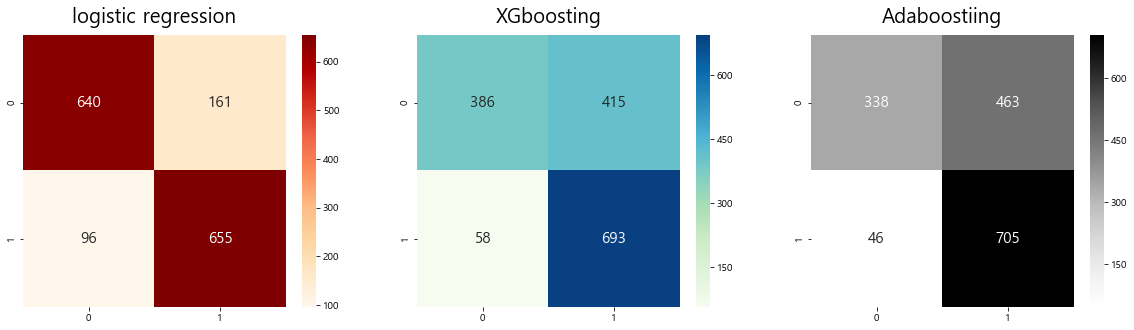

In [566]:
# confusion matrix
from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(20, 5))

confu = confusion_matrix(y_true = y_test, y_pred = lr2_pred)
confu2 = confusion_matrix(y_true = y_test, y_pred = XGB2_pred)
confu3 = confusion_matrix(y_true = y_test, y_pred = AB2_pred)


sns.heatmap(confu, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g', ax=ax[0])
sns.heatmap(confu2, annot=True, annot_kws={'size':15}, cmap='GnBu', fmt='.10g', ax=ax[1])
sns.heatmap(confu3, annot=True, annot_kws={'size':15}, cmap='Greys', fmt='.10g', ax=ax[2])
ax[0].set_title('logistic regression',pad = 12, fontsize = 20)
ax[1].set_title('XGboosting',pad = 12, fontsize = 20)
ax[2].set_title('Adaboostiing',pad = 12, fontsize = 20)
plt.show()

#### <font color=yellow>Grid Search CV (hyper parameter 개선)</font>

In [567]:
from sklearn.model_selection import GridSearchCV

In [568]:
params = {'penalty':['l2','l1'],
'C':list(range(1,10))
}

In [569]:
grid_lr = GridSearchCV(lr2,\
                         param_grid=params , scoring='accuracy' , cv=5)
grid_lr.fit(x_train , y_train)

df_grid_lr = pd.DataFrame(grid_lr.cv_results_)
pd.set_option('display.max.colwidth', 200)
df_grid_lr[['params','mean_test_score','rank_test_score','split0_test_score','split1_test_score','split2_test_score']]\
.sort_values('rank_test_score').head(10)

,params,mean_test_score,rank_test_score,split0_test_score,split1_test_score,split2_test_score
6,"{'C': 4, 'penalty': 'l2'}",0.824033,1,0.820442,0.824586,0.824586
8,"{'C': 5, 'penalty': 'l2'}",0.823757,2,0.821823,0.825967,0.821823
4,"{'C': 3, 'penalty': 'l2'}",0.823481,3,0.820442,0.825967,0.823204
2,"{'C': 2, 'penalty': 'l2'}",0.822652,4,0.823204,0.827348,0.820442
10,"{'C': 6, 'penalty': 'l2'}",0.822652,4,0.821823,0.825967,0.817680
12,"{'C': 7, 'penalty': 'l2'}",0.821547,6,0.812155,0.825967,0.821823
16,"{'C': 9, 'penalty': 'l2'}",0.820994,7,0.810773,0.825967,0.824586
14,"{'C': 8, 'penalty': 'l2'}",0.819061,8,0.808011,0.825967,0.819061
0,"{'C': 1, 'penalty': 'l2'}",0.818785,9,0.828729,0.819061,0.817680
9,"{'C': 5, 'penalty': 'l1'}",0.787845,10,0.792818,0.772099,0.792818


In [570]:
bestlr = grid_lr.best_estimator_

bestlr_pred = bestlr.predict(x_test)
print('accuracy: %.4f' % accuracy_score(y_test , bestlr_pred))
print('precision: %.4f' % precision_score(y_test, bestlr_pred))
print('recall: %.4f' % recall_score(y_test, bestlr_pred))
print('F1: %.4f' % f1_score(y_test, bestlr_pred))

accuracy: 0.8254
precision: 0.8030
recall: 0.8469
F1: 0.8244


#### <font color=yellow>ROC Curve</font>

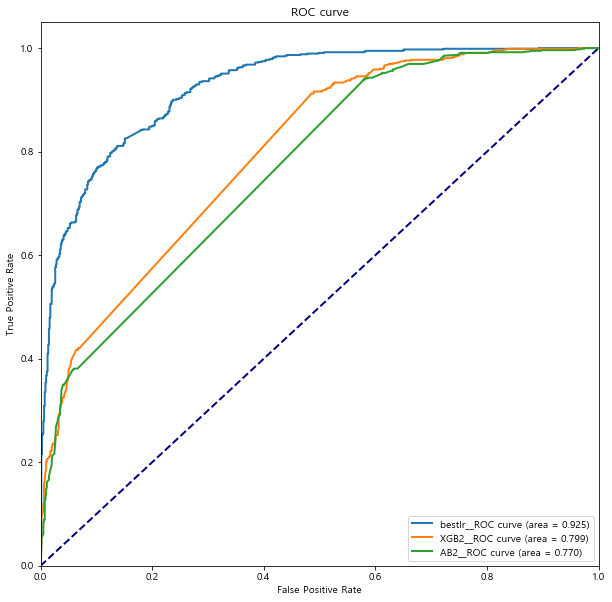

In [571]:
models=[ 'bestlr', 'XGB2', 'AB2']


plt.figure(figsize=(10, 10))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title("ROC curve")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')


# Global 변수 (전역 변수)
# string으로 변수를 설정하고, 값을 할당의 목적으로 사용

for i in models:

    globals()['{}_pred'.format(i)] = \
    globals()['{}'.format(i)].predict_proba(x_test)
    
    globals()['{}_roc'.format(i)]=\
    globals()['{}_pred'.format(i)][:,1]
   
    globals()['fpr_{}'.format(i)],\
    globals()['tpr_{}'.format(i)], \
    globals()['_{}'.format(i)] \
    =roc_curve(y_true=y_test, y_score=globals()['{}_roc'.format(i)]) 
    
    globals()['roc_auc_{}'.format(i)] = \
    auc(globals()['fpr_{}'.format(i)], globals()['tpr_{}'.format(i)])
    
    
    
    plt.plot(globals()['fpr_{}'.format(i)], globals()['tpr_{}'.format(i)]
             , lw=2, label=i+'__ROC curve (area = %0.3f)' %globals()['roc_auc_{}'.format(i)])

plt.legend()
plt.show()

In [572]:
# # print logistic regression's coef

# plt.figure(figsize=(10, 10))
# plt.bar(range(len(lr2.coef_[0])), lr2.coef_[0])

#### <font color=yellow>Coefficient & 단어 Mapping</font>

In [573]:
print(sorted(((value, index) for index, value in enumerate(lr2.coef_[0])), reverse = True)[:5])
print(sorted(((value, index) for index, value in enumerate(lr2.coef_[0])), reverse = True)[-5:])
# enumerate: 인덱스 번호와 컬렉션의 원소를 tuple형태로 반환함

[(2.7870838551442905, 15646), (2.7253313915623454, 17900), (2.4748953888495593, 939), (2.2921495534756926, 15696), (2.2594539041635486, 8962)]
[(-2.848461834234115, 11540), (-2.931398071710636, 12882), (-2.992829089099804, 1228), (-3.332433544544398, 17917), (-3.562309631147823, 3810)]


In [574]:
coef_pos_index = sorted(((value, index) for index, value in enumerate(lr2.coef_[0])), reverse = True)
coef_neg_index = sorted(((value, index) for index, value in enumerate(lr2.coef_[0])), reverse = False)

In [575]:
invert_index_vectorizer = {v: k for k, v in vect.vocabulary_.items()}
print(str(invert_index_vectorizer)[:1000]+'..')

{15651: '재밌고', 2366: '기대', 12858: '엄청', 15696: '재밌어요', 20278: '후회', 15997: '절대', 19361: '하실', 15692: '재밌어서', 15240: '자막', 13024: '없이', 8594: '보려고', 8621: '보세오', 2211: '그리스', 8157: '배경', 17810: '청량한', 4106: '느낌', 19627: '항상', 13944: '웃고', 15031: '있는', 18961: '표정', 16764: '중독', 1081: '강한', 346: 'ost', 3908: '높은', 18422: '탄탄한', 10852: '스토리', 11749: '아니지만', 19937: '행복해지고', 8539: '보는', 14763: '인생', 10578: '손영주', 16368: '좋네요', 17956: '추천', 13196: '역시', 11180: '실망', 11045: '시키지', 12239: '않았음', 1055: '강렬해서', 5620: '들을', 6236: '마다', 778: '가슴', 1868: '괜히', 7562: '뭉클해져', 14727: '인간', 18443: '탐욕', 14359: '이기심', 15874: '적나라하게', 5431: '드러낸', 7083: '명작', 19455: '한국영', 15298: '자체', 16224: '조우진', 19910: '했음', 8554: '보는내내', 2501: '긴장감', 15116: '있었어요', 17107: '진기', 4684: '대박', 6299: '마지막', 14631: '이었음', 16680: '죽을지', 7230: '몰라야', 9718: '사는게', 15679: '재밌다는게', 8091: '발암', 15923: '전개', 12151: '안타깝지만', 1603: '고르', 2411: '기라', 7751: '믿고', 1237: '개인', 16453: '좋았습니다', 18887: '평점', 6289: '마이너스', 12897: '없나요', 46

In [576]:
for coef in coef_pos_index[:20]:
    print(invert_index_vectorizer[coef[1]], coef[0])

재밌게 2.7870838551442905
최고 2.7253313915623454
감동 2.4748953888495593
재밌어요 2.2921495534756926
봤습니다 2.2594539041635486
봤어요 2.10414836132011
재밌었어요 1.8285002371494536
마음 1.8147266293153508
좋았어요 1.7940075825080615
좋고 1.7270775085655745
좋았습니다 1.7065685182107548
생각 1.6801167930982992
재밌음 1.6733577243903723
눈물 1.6632059064811295
재미있게 1.6492479188601266
조우진 1.6458067824356433
나름 1.6199624315853074
명작 1.600553470393871
좋았다 1.6001891869093317
오랜 1.5973604389168612


In [577]:
for coef in coef_neg_index[:20]:
    print(invert_index_vectorizer[coef[1]], coef[0])

노잼 -3.562309631147823
최악 -3.332433544544398
개연 -2.992829089099804
없고 -2.931398071710636
쓰레기 -2.848461834234115
아깝다 -2.4043846365306822
고구마 -2.3214939160824093
경찰 -2.1773330561798527
아까 -2.148232839038673
광고 -2.0186422754406883
보다가 -1.9786072960379124
알바 -1.938468255248286
이렇게 -1.935766294955794
예고편 -1.898162565539131
이딴 -1.6966007281349806
재미없는 -1.6603777962002209
낭비 -1.6270989721396747
억지 -1.5846309684133413
라고 -1.5705620324556384
아까운 -1.5693186230819256


# <font color=#cccccc>입력 TEXT에 대한 감정 예측</font>

In [578]:
df_word_and_numb = pd.DataFrame(list(vect.vocabulary_.items()), columns=['word','word_num'])
df_score_and_numb = pd.DataFrame(coef_pos_index,columns=['score','word_num'])
df_final = pd.merge(df_word_and_numb, df_score_and_numb ,how = 'inner', on = 'word_num')
df_final

,word,word_num,score
0,재밌고,15651,1.465901
1,기대,2366,1.312318
2,엄청,12858,0.914267
3,재밌어요,15696,2.292150
4,후회,20278,0.464690
5,절대,15997,-0.742871
6,하실,19361,0.076531
7,재밌어서,15692,0.592420
8,자막,15240,0.140112
9,없이,13024,1.189179


In [579]:
# input되는 string을 점수로 바꿔주는 작업
test_text = str(input("리뷰를 달아주세요 (예시: 정말 재미있었어요!): "))
okt.pos(test_text, norm=True, stem=True)
clnd_txt = text_cleaning(test_text)


# 점수 계산기
sum_of_coef = 0
count_of_sum = 0
for text in clnd_txt:
    if text in list(df_final['word']):
        sum_of_coef += float(df_final[df_final['word']==text]['score'])
        count_of_sum += 1

        
# 긍정, 부정 판독기
if count_of_sum != 0:
    final_score = sum_of_coef/count_of_sum
    print(final_score)
    if final_score >0.1:
        print('영화가 좋았군요!')
    elif final_score <-0.1 :
        print('영화가 취향에 맞지 않으셨군요ㅠㅠ')
    else :
        print('그저그러셨군요!')
else :
    print("무슨 말씀인지 이해하지 못했어요.")

리뷰를 달아주세요 (예시: 정말 재미있었어요!): 정말 재미있었어요!
0.9376431391446941
영화가 좋았군요!


# Appendix(유사 리뷰 영화 확인을 위한 cos 유사도검정)

In [580]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity

In [581]:
df_cos = pd.read_csv('naver_movie.csv', encoding='utf-8')

In [582]:
# 결측치 제거
df_cos.dropna(axis = 0, inplace=True)
df_cos.reset_index(inplace=True)
del df_cos['index']

In [583]:
# 라벨 인코딩(영화명->영화number)
le = LabelEncoder()
df_cos['title_num']=pd.DataFrame(le.fit_transform(df_cos['title']))

In [584]:
# 리뷰데이터 100개 이상인 영화만 남기기
df_cos['count'] = \
df_cos.groupby(['title_num'])['number'].transform('count')

df_cos = df_cos[df_cos['count']>100]
df_cos.reset_index(inplace=True)
del df_cos['index']
df_cos.head()

,title,number,score,text,title_num,count
0,콰이어트 플레이스 2,17583235,9,1편보다 재밌고 3편이 기대되는 2편,1349,368
1,콰이어트 플레이스 2,17583230,10,역시 실망시키지 않았음,1349,368
2,발신제한,17583226,7,그냥 한국영화 그 자체 조우진 연기는 볼만했음,596,630
3,미드나이트,17583225,8,보는내내 긴장감 있었어요진기주 위하준 연기대박!,545,1247
4,발신제한,17583223,6,원작 그대로 따라하고 ㅎ삼성차는 터지고 제네시스는 이쁘게나옴 ㅋ조우진 연기는 딱여기까지인듯,596,630


In [585]:
def all_func(text):
    result = ', '.join(text_cleaning(text))
    return result

In [586]:
# all 값 적용
df_cos['text'] = df_cos['text'].map(lambda x : all_func(x))

In [587]:
df_cos

,title,number,score,text,title_num,count
0,콰이어트 플레이스 2,17583235,9,"재밌고, 기대",1349,368
1,콰이어트 플레이스 2,17583230,10,"역시, 실망, 시키지, 않았음",1349,368
2,발신제한,17583226,7,"한국영, 자체, 조우진, 했음",596,630
3,미드나이트,17583225,8,"보는내내, 긴장감, 있었어요, 진기, 대박",545,1247
4,발신제한,17583223,6,"원작, 그대로, 따라하고, 삼성, 차는, 터지고, 제네시스, 이쁘게나, 조우진, 딱여기까지, 인듯",596,630
5,콰이어트 플레이스 2,17583222,7,"발암, 전개, 안타깝지만, 고르, 기라, 믿고",1349,368
6,제8일의 밤,17583220,1,"평점, 마이너스, 없나요, 대단한거, 같아요, 상황, 이든, 감정이입, 해야하니까, ㅠㅠ, 같은, 장르, 에서도, 최선, 다한, 에겐, 높이, 평가, 한국, 아니라, 타이완, 이나, 베트남, 사람, 데리, 드셧, 좋겠어요",1210,1837
7,어른들은 몰라요,17583219,9,"연출, 좋았고, 사람, 마다, 닿는, 다르겠지만, 한텐, 개인, 울림이있는, 였다고, 생각, 한다, 단순히, 하니, 궁금해서, 봤는데, 괜히, 먹하고, 복잡한, 생각, 드는",978,106
8,제8일의 밤,17583215,10,"여고생, 소름",1210,1837
9,미드나이트,17583213,9,"명작, 추격자, 답답혀, 개연, 따지지, 말어",545,1247


In [588]:
# 영화제목 list backup
df_title_list = df_cos[['title','title_num']]

# 중복제거를 통해, indexing
df_title_list = df_title_list.drop_duplicates(inplace=False)
df_title_list.reset_index(inplace=True)
del df_title_list['index']
df_title_list

,title,title_num
0,콰이어트 플레이스 2,1349
1,발신제한,596
2,미드나이트,545
3,제8일의 밤,1210
4,어른들은 몰라요,978
5,괴기맨숀,113
6,크루엘라,1358
7,체르노빌 1986,1288
8,컨저링 3: 악마가 시켰다,1330
9,빛나는 순간,703


In [589]:
# 영화별 말뭉치 생성

corpus_cos = []
for title in df_title_list['title_num']:
    globals()['df_cos_{}'.format(title)] = df_cos[df_cos['title_num']==title]
    globals()['corpus_{}'.format(title)] = "".join(globals()['df_cos_{}'.format(title)]['text'].tolist())
    corpus_cos.append(globals()['corpus_{}'.format(title)])

In [590]:
corpus_cos[0][:100]

'재밌고, 기대역시, 실망, 시키지, 않았음발암, 전개, 안타깝지만, 고르, 기라, 믿고중반, 부가, 루즈, 했고, 어디서, 튀어나올지, 상이, 가서, 공포영화, 같았음, 진심, 놀'

In [591]:
X = TfidfVectorizer().fit_transform(corpus_cos).todense()

In [592]:
len(X)

13

In [607]:
for i in range(len(X)-1):
    for j in range(i+1,len(X)):
        if cosine_similarity(X[i],X[j])>0.25:
            print("{}, {} 영화 간_ cosine 유사도: {:.2f}%"\
                  .format(df_title_list['title'][i], df_title_list.iloc[j,0] ,100*float(cosine_similarity(X[i],X[j]))))

콰이어트 플레이스 2, 미드나이트 영화 간_ cosine 유사도: 29.30%
콰이어트 플레이스 2, 제8일의 밤 영화 간_ cosine 유사도: 34.56%
발신제한, 미드나이트 영화 간_ cosine 유사도: 28.24%
발신제한, 제8일의 밤 영화 간_ cosine 유사도: 26.33%
미드나이트, 제8일의 밤 영화 간_ cosine 유사도: 36.22%
제8일의 밤, 괴기맨숀 영화 간_ cosine 유사도: 29.78%
괴기맨숀, 컨저링 3: 악마가 시켰다 영화 간_ cosine 유사도: 26.41%


https://tacademy.skplanet.com/frontMain.action

40분 내외의 짧은 영상으로 벡터부터 matrix factorization / SVD / Embedding / 추천시스템 / PCA 등과 관련된 일련의 흐름을 설명해주는 좋은 영상이 있어 공유드려요! ㅎㅎ<br>
Tensorflow 공식 채널의 ML Tech Talks 중 하나입니다!<br>

https://www.youtube.com/watch?v=LlKAna21fLE<br>
선형대수를 따로 배워보지 않으셨거나 내용이 궁금하신 분들은 슥슥 한번 시청해보셔요!<br>